In [1]:
pip install bcrypt pyotp qrcode pillow

Note: you may need to restart the kernel to use updated packages.


# Section 1: Password Strength Analysis

When analysing the strength of a password, we can use a scoring system to evaluate a password and award points based on certain factors. These factors can include:
- **Length Check:** Longer passwords award more points.
- **Character Variety:** A password containing a wide variety of characters- such as upper case, lower case, numbers and symbols- would award more points.
- **Common Passwords Check:** This checks the password entered against a list of known common passwords. Points may be taken away if it matches the list or awarded if it doesn't.
- **Entropy:** This is a measure of how random the password is.

In [18]:
import string

password = 'H!?lo1ooo'

The following code is a helper function that is used in the `passStrength` function and the `aprxEntropy` function.

In [19]:
# Module for traversing through password and identifying 4 character types. 
# Second argument can be 0 or 1. 
# If 0, function will return a number of points. If 1, function will return the pool size.
def passCharType(password, plOrPnt):
    points = 0
    pool = 0
    digits = False
    pun = False
    lc = False
    uc = False

    for x in password:
        if x in string.digits and not digits:
            points += 1
            pool += 10
            digits = True

        if x in string.punctuation and not pun:
            points += 1
            pool += 32
            pun = True

        if x in string.ascii_lowercase and not lc:
            points += 1
            pool += 26
            lc = True
            
        if x in string.ascii_uppercase and not uc:
            points += 1
            pool += 26
            uc = True

    if plOrPnt == 0:
        return points
    elif plOrPnt == 1:
        return pool
    else:
        return

print(passCharType(password, 0)) # This will output the number of points.
print(passCharType(password, 1)) # This will output the pool size.

4
94


Another helper function. This is to check if the password is the same as any of the common password in the `dictionary.txt` file.

In [20]:
def comm_pass_check(password):
    with open('dictionary.txt') as x:
        # Iterate through each line in the dictionary
        for line in x:
            comm_pass = line.strip()
            
            # Compare against target_hash
            if password == comm_pass:
                return True

Helper function to find entropy.

In [21]:
import math

# Function for approximate entropy
def aprxEntropy(password):
    length = len(password)
    pool = passCharType(password, 1)

    return length * math.log2(pool)

print(aprxEntropy(password))

58.99129966509874


The function below returns a score for the strength of the password.

In [39]:
# Function that returns final strength of password through points.
def passStrength(password):
    points = 0
    length= len(password)

    if length > 7:
        points += 1
    if length > 11:
        points += 1

    points += passCharType(password, 0)

    if comm_pass_check(password) == True:
        print("Password has been found in a databreache. Please choose a different password.")
        points = 0
        return points

    entropy = aprxEntropy(password)

    # Award points based on entropy value.
    if entropy < 36:
        points -= 2
    elif entropy >= 36 and entropy < 60:
        points += 1
    elif entropy >= 60 and entropy < 128:
        points += 2
    elif entropy >= 128:
        points += 3

    return points


print(passStrength('password@23'))  # Example usage

6


# Section 2: Don't Store Passwords, Store Hashes!

It is incredibly important to hash passwords before storing them in a database. This is because if you store passwords simply as plain text, attackers will immediately acquire all the passwords if they are able to steal your database. When you hash passwords before storing them, even if a hacker steals your database, they will need to spend a lot of time and resources to decrypt all the passwords.

Hashing passwords is especially imperative to security, because many users reuse their passwords across services. This means that if a hacker acquires a user's password for your service, they also gain access to all of the user's data across all their services.

There is also a risk of insider threat. Any employee, such as a database administrator or developer with access to the database can read the passwords if they are plain text.

Additionally, storing passwords as plain text violates UK GDPR. It is the legal responsibilty of an organisation to apply reasonable security measures, such as hashing, when storing user passwords. (https://ico.org.uk/for-organisations/uk-gdpr-guidance-and-resources/security/a-guide-to-data-security/passwords-in-online-services/)

## 1. Hash with SHA256 and MD5:

SHA256 and MD5 are both fast hashing algorithms. These algorithms are great for checking file integrity as it allows for quick comparison of files. However, this speed makes it very quick and easy for hackers to crack the hashed passwords.

In [18]:
password = 'password123'

from hashlib import sha256

hash = sha256(password.encode('utf-8')).hexdigest()

print(hash)

ef92b778bafe771e89245b89ecbc08a44a4e166c06659911881f383d4473e94f


In [19]:
from hashlib import md5

hash = md5(password.encode('utf-8')).hexdigest()

print(hash)

482c811da5d5b4bc6d497ffa98491e38


## 2. Hash with bcrypt:

Hashing with bcrypt is much more secure in comparison. This is because bcrypt is intentionally made to be slow, so that hackers take much longer to crack the passwords. You can even use a cost factor to increase the number of iterations (hashing rounds) to make the algorithm even slower.

In [28]:
import bcrypt

def bcryptHash(password):
    pBytes = password.encode('utf-8') # Converts into byte sequence/array.

    salt = bcrypt.gensalt()

    hash = bcrypt.hashpw(pBytes, salt) # Hashes using password byte sequence and salt as arguments.

    return hash

print(bcryptHash(password))

b'$2b$12$hKNu2MoIrTOhaNn9wOGh8.7jqmW/3ptsl/op7/27A4NEHr.qJJ/Fy'


Function `bcryptHash` created for future use.

### 3. Compare hashes with bcrypt:

In [30]:
userInput = 'passWord'

userPBytes = userInput.encode('utf-8')

check = bcrypt.checkpw(userPBytes, bcryptHash(password)) # Checks if password matches. You cannot flip the order of the arguments.

print(check)

False


In [31]:
userInput = 'password123'

userPBytes = userInput.encode('utf-8')

check = bcrypt.checkpw(userPBytes, bcryptHash(password)) # Checks if password matches. You cannot flip the order of the arguments.

print(check)

True


# Section 3: Adding Salt and Pepper

In addition to being slow, bcrypt also adds a salt to the passwords. This is a randomly generated value added to the password that defends the passwords against rainbow table attacks. A rainbow table attack is a type of dictionary attack where a hacker uses a rainbow table. A rainbow table is a precomputed table that holds hash values for a list of common passwords. Salting passwords prevents this type of attack because it ensures that the hash of a password isn't the same every time it is hashed. (https://www.beyondidentity.com/glossary/rainbow-table-attack)

For example:
```
$2a$12$R9h/cIPz0gi.URNNX3kh2OPST9/PgBkqquzi.Ss7KIUgO2t0jWMUW
\__/\/ \____________________/\_____________________________/
Alg Cost      Salt                        Hash
```

(https://en.wikipedia.org/wiki/Bcrypt)

In [20]:
password = 'user123password'

## 1. Without Salt:

In [21]:
hash = sha256(password.encode('utf-8')).hexdigest()

print(hash)

6384e02d9a47ac61c64950915c878ea54cc91a3d9c11d7497818017db8356d2a


In [22]:
hash = sha256(password.encode('utf-8')).hexdigest()

print(hash)

6384e02d9a47ac61c64950915c878ea54cc91a3d9c11d7497818017db8356d2a


Without the salt the hashes of the same password using sha256 is exactly identical. This makes the password vulnerable to a rainbow table attack.

## 2. With Salt:

In [23]:
print(bcryptHash(password))

b'$2b$12$TjPCxQjzf03HwAtNc7NGxe1zIThY7.QFq12Mge9Lq7JXf3eNbvRvm'


In [24]:
print(bcryptHash(password))

b'$2b$12$8ob5AblmmXrW6/DjWAuXZuO9nK0sKxSkBzEauxuM8iM0F9OGdyKWe'


With the salt, the hashes are different even though the passwords are the same.

## 3. With Pepper:

A pepper is a secret value added to the password in addition to the salt. This pepper is then hashed along with the salted password. The pepper is randomly generated and is the same for all passwords in the database. Unlike salts, the pepper is stored separate from the database in the application's configuration or environment variable. (https://nordpass.com/blog/pepper-password/)

Adding a pepper in addition to salts adds an extra layer of security. While salts slow down the cracking of the hashed passwords, it doesn't completely stop it. Peppering your password will stop attackers from being able to crack the hashed password, as the pepper (be it hashed or not) is not available to them.

There are more than one way of applying pepper to a password. Some of the ways include:
1. To use bcrypt to salt the password and hash, then add the pepper and hash again without salt. That should look like this: `hash(pepper + salt + password)`
2. The other way is to add the pepper to the password prior to hashing, then salting the whole thing and hashing it all just once. That shoud look like this: `hash(pepper + hash(salt + password))`

The second method is more convenient for me as it allows me to use my previous `bcryptHash` function.

Below we use the python `secrets` module instead of the `random` module to generate the pepper. This is because the `random` module is pseudo-random generator that uses the Mersenne Twister algorithm, to generate a number using a strating point or seed, that is usually the current time. This makes the pseudo-random number reverse engineerable.

On the other hand, the `secrets` module uses an API provided by the OS to generate a truly random value.

In [1]:
import secrets

pepper = secrets.token_bytes()

print(pepper)

b'\xe8;\xd4\nx\xe2(e\x19\x93A\xb9%-\t\xfa\x97R\xb7\x15\xaa\x16\x16\x88\x81fw\xc5\x88\x9f`F'


In [42]:
hash1 = bcryptHash(password)

print(hash1)

b'$2b$12$o5JdFn/S3RSgWBp9cjFp5eN9CRkCIb8MVl6aVhvrj06hh.XtoeDBO'


In [43]:
pepperedHash = pepper + hash1

hash2 = sha256(pepperedHash).hexdigest()

print(hash2)

1356870e59de9fad3d988ab5bdc87c8a65fdff097be59f4e4b7925581c4ef4dd


# Section 4: Implementing Two-Factor Authentication (2FA)

Two-factor authentication is security process where the user must provide 2 pieces of verification to prove their identity to the system. This is usually 'something you know', like your password, and 'something you have', like your phone. 

The second verification is commonly done using SMS text-based codes, but the downside of this is that SMS has low security. It is vulnerable to SIM swapping, man-in-the-middle attacks and more.

A more secure second verification is time-based one-time passwords (TOTP). This works by using a shared secret key to generate a temporary, single-use password/pin based on the current time. The code below simulates how TOTP works. 

In [ ]:
# pip install pyotp

  Using cached pyotp-2.9.0-py3-none-any.whl.metadata (9.8 kB)
Using cached pyotp-2.9.0-py3-none-any.whl (13 kB)


In [ ]:
# pip install qrcode

  Using cached qrcode-8.2-py3-none-any.whl.metadata (17 kB)
Using cached qrcode-8.2-py3-none-any.whl (45 kB)


In [5]:
import pyotp
import qrcode

secretKey= pyotp.random_base32() # Generate a random base32 secret key.
print(secretKey)

SL3XVWMSXGBQ6QYASKPFJRECYRBKH2GW


In [9]:
accountName = 'abrarur.bhuiyan@outlook.com'
issuerName = 'Google Authenticator'

uri = pyotp.totp.TOTP(secretKey).provisioning_uri(
    name=accountName,
    issuer_name=issuerName
)

print(uri)

otpauth://totp/Google%20Authenticator:abrarur.bhuiyan%40outlook.com?secret=SL3XVWMSXGBQ6QYASKPFJRECYRBKH2GW&issuer=Google%20Authenticator


By scanning the QR code below with my phone, the authenticator app on my phone receives the secret key.

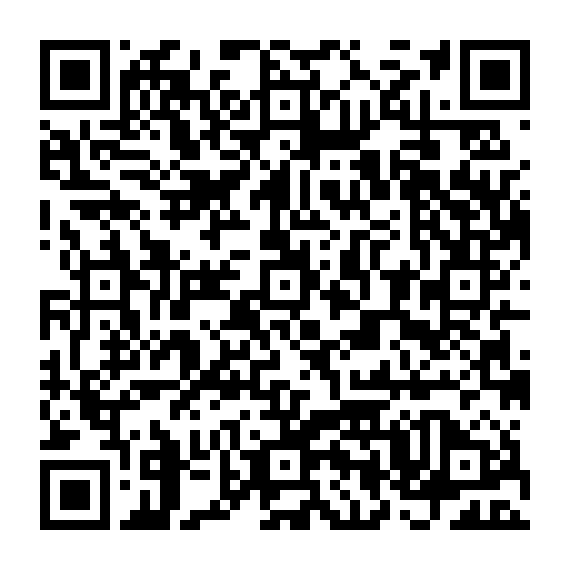

In [10]:
img = qrcode.make(uri)

img

Authenticator app on my phone will generate a new code every 30 seconds (default value) that matches the value generated by the code below.

In [11]:
totp = pyotp.TOTP(secretKey)
print(f'Current code: {totp.now()}.')

Current code: 732056.


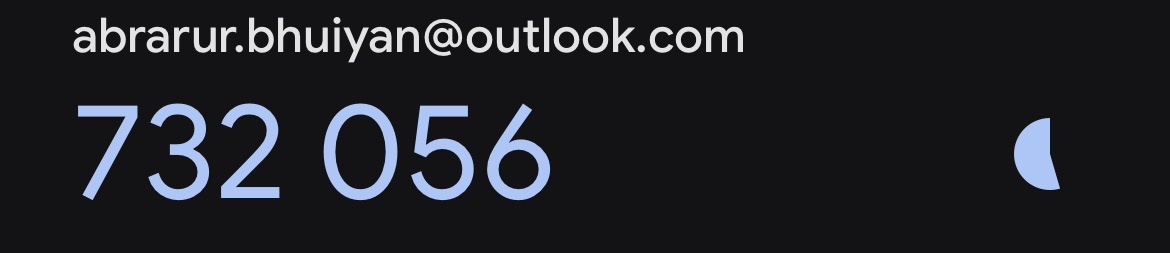

**They match!**

# (Challenge) Section 5: Simulating a Brute-Force

## Brute-Force Attack

This is an attack where an attacker attemps every password combination until they find the correct one. This is extremely time-consuming and works best against short passwords, but it is guaranteed to work eventually.

## Dictionary Attack

Dictionary attacks works by using a list of commonly used passwords. This can be a list of common words, names or phrases. This attack is much faster as there is a limited list of possible passwords it tries. The downside is that unlike brute-force attacks, dictionary attacks only work if the password is weak/ common.

Dictionary attacks can be online or offline.

For an online attack, the attacker uses the website or application's login page to execute the attack. This can be easily prevented using lockouts or rate limiting, which makes this type of attack unfeasible.

For an offline attack, the attacker manages to steal the database file containing user passwords. The attacker then hashes the passwords in their dictionary and compares them against the hashed passwords in the stolen database. Salting the passwords in the database makes it very slow and difficult to crack the passwords.

## Function to Simulate a Dictionary Attack:

The following function takes two arguments: `target_hash` and `hash_type`. It iterates over each line in the `dictionary.txt` file. For each line it hashes the password and compares it against the `target_hash`. 

If the hash of the password in the dictionary matches the `target_hash`, the function outputs a message with the cracked password and the time taken to crack.

If the function could not find the password it outputs a message saying 'password not found'.

The function accepts the following hash_types:
- `sha256`
- `md5`
- `bcrypt`

This function demonstrates the time taken to crack a fast hash, such as `sha256` and `md5`, compared to a slow hash like `bcrypt`.

In [40]:
from hashlib import sha256, md5
import time
import bcrypt

def dict_attack(target_hash, hash_type):
    startTime = time.time()

    with open('dictionary.txt') as x:
        # Iterate through each line in the dictionary
        for line in x:
            password = line.strip()
            hash = ''
            
            # Hash the password based on the hash_type:
            if hash_type == 'sha256':
                hash = sha256(password.encode('utf-8')).hexdigest()

            elif hash_type == 'md5':
                hash = md5(password.encode('utf-8')).hexdigest()

            elif hash_type == 'bcrypt':
                # Compare using bcrypt's checkpw function
                if bcrypt.checkpw(password.encode('utf-8'), target_hash):
                    endTime = time.time()
                    print(f"Success! Password found: {password}")
                    print(f"Time taken: {endTime - startTime} seconds")
                    return
            
            # Compare against target_hash
            if hash == target_hash:
                endTime = time.time()
                print(f"Success! Password found: {password}")
                print(f"Time taken: {endTime - startTime} seconds")
                return

    print("Password not in dictionary.")

In [42]:
dict_attack('ef92b778bafe771e89245b89ecbc08a44a4e166c06659911881f383d4473e94f', 'sha256') # The target_hash is for 'password123'.

Success! Password found: password123
Time taken: 0.0 seconds


In [43]:
dict_attack('482c811da5d5b4bc6d497ffa98491e38', 'md5') # The target_hash is for 'password123'.

Success! Password found: password123
Time taken: 0.0 seconds


In [44]:
dict_attack(bcrypt.hashpw('password123'.encode('utf-8'), bcrypt.gensalt()), 'bcrypt') # The target_hash is for 'password123'.

Success! Password found: password123
Time taken: 1.227226972579956 seconds


Above are the results of the dictionary attack. The dictionary attack using `sha256` and `md5` took close to 0 seconds to crack the password. On the other hand, `bcrypt` takes much longer.

# Section 6: Building the Complete System

In [37]:
from hashlib import sha256, md5
import time
import bcrypt
import pyotp
import qrcode

users = {}

def register_user(username, password):
    if passStrength(password) < 5:
        print("Password is too weak. Please choose a stronger password.")
        return

    # Hash the password using bcrypt
    pBytes = password.encode('utf-8')
    salt = bcrypt.gensalt()
    hashed_password = bcrypt.hashpw(pBytes, salt)

    # Generate a TOTP secret key
    secret_key = pyotp.random_base32()

    # Store user information
    users[username] = {
        'hashed_password': hashed_password,
        'secret_key': secret_key
    }

    # Generate provisioning URI for TOTP
    uri = pyotp.totp.TOTP(secret_key).provisioning_uri(
        name=username,
        issuer_name='Google Authenticator'
    )

    img = qrcode.make(uri)

    print('Scan this QR code with your authenticator app for TOTP codes when logging in:')
    img.show()


def authenticate(username, password, totp_code):
    if username not in users:
        print("User not found.")
        return

    user_info = users[username]
    pBytes = password.encode('utf-8')

    # Verify password
    if not bcrypt.checkpw(pBytes, user_info['hashed_password']):
        print("Incorrect password.")
        return

    # Verify TOTP code
    totp = pyotp.TOTP(user_info['secret_key'])
    if not totp.verify(totp_code):
        print("Invalid TOTP code.")
        return

    print("Authentication successful!")
    return


#### Registration Test Cases:

In [40]:
register_user('abr', 'password123')

Password has been found in a databreache. Please choose a different password.
Password is too weak. Please choose a stronger password.


In [41]:
register_user('abr', 'password')

Password is too weak. Please choose a stronger password.


In [42]:
register_user('abr', 'StrongPass!23')

Scan this QR code with your authenticator app for TOTP codes when logging in:


#### Authentication Test Cases:

In [47]:
authenticate('abr', 'StrongPass!23', int(input("Enter TOTP code: ")))

Authentication successful!


In [48]:
authenticate('abr', 'StrongPass!23', int(input("Enter TOTP code: ")))

Invalid TOTP code.


In [49]:
authenticate('abr', 'StrongPass', int(input("Enter TOTP code: ")))

Incorrect password.


In [50]:
authenticate('abasdr', 'StrongPass!23', int(input("Enter TOTP code: ")))

User not found.
